In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '6, 7'

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn.functional as F
from torchvision import transforms
from torchvision import models
from torch.autograd import Variable
import torch.nn as nn
from torch.optim import lr_scheduler
from torch import optim
from torchvision.utils import make_grid
from glob import glob
import joblib

In [3]:
class MultiClassifier(nn.Module):
    def __init__(self):
        super(MultiClassifier, self).__init__()
        self.ConvLayer1 = nn.Sequential(
            nn.Conv2d(3, 64, 3), # 3, 256, 256
            nn.MaxPool2d(2), # op: 16, 127, 127
            nn.ReLU(), # op: 64, 127, 127
        )
        self.ConvLayer2 = nn.Sequential(
            nn.Conv2d(64, 128, 3), # 64, 127, 127   
            nn.MaxPool2d(2), #op: 128, 63, 63
            nn.ReLU() # op: 128, 63, 63
        )
        self.ConvLayer3 = nn.Sequential(
            nn.Conv2d(128, 256, 3), # 128, 63, 63
            nn.MaxPool2d(2), #op: 256, 30, 30
            nn.ReLU() #op: 256, 30, 30
        )
        
        self.Linear1 = nn.Linear(256*14*14, 64)
        self.Linear2 = nn.Linear(64, 2)
                
        
    def forward(self, x):
        x = self.ConvLayer1(x)
        x = self.ConvLayer2(x)
        x = self.ConvLayer3(x)

        x = x.view(x.size(0), -1)
        x = self.Linear1(x)
        x = self.Linear2(x)
        return F.softmax(x)

In [4]:
model = MultiClassifier()

In [5]:
model.load_state_dict(torch.load('./celeba_cls.pth'))

<All keys matched successfully>

In [6]:
model = model.cuda()

In [7]:
# should be changed to the path of generated celeba data

base = '/data/local/qipan/exp_celeba/logs/RANDOM_0116_CELEBA_EXP_EXP10_K256_IMAGE_SIZE_28_BATCH_128_IMPROVED/samples' 

In [8]:
images = glob(base + '/image*')

In [9]:
# images

In [9]:
len(images)

60

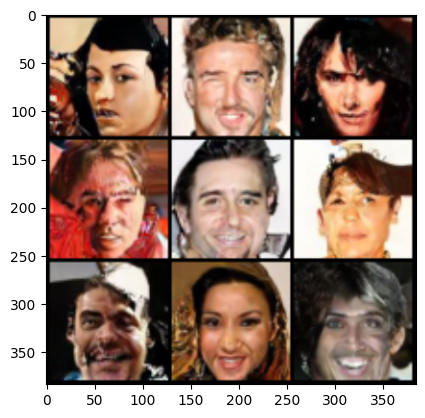

In [10]:
x = Image.open(images[0])

transform=transforms.Compose([
    transforms.Resize((128*3,128*3)),
    transforms.ToTensor()
])

# transform=transforms.Compose([
#     transforms.ToTensor()
# ])

x = transform(x)

plt.imshow(x.permute(1,2,0))

In [11]:
x.shape

torch.Size([3, 384, 384])

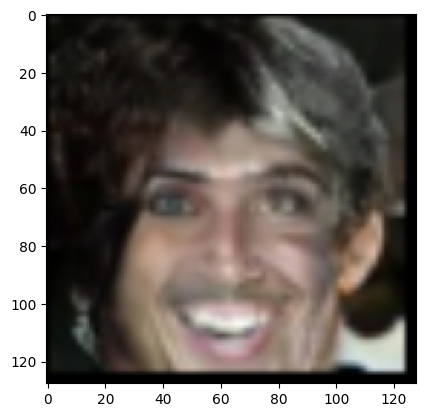

In [12]:
plt.imshow(x[:,128*2:128*3,128*2:128*3].permute(1,2,0))

In [13]:
model(x[:,128*2:128*3,128*2:128*3].unsqueeze(0).cuda())

/tmp/ipykernel_3571855/3814926896.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


tensor([[6.4064e-11, 1.0000e+00]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [14]:
train_x = []
train_y = []

In [15]:
from time import time

In [17]:
st = time()

for ix, img in enumerate(images):
    for i in range(3):
        for j in range(3):
            if ix % 100 == 0:
                print(ix, time() - st)
            # split images 6*6 one by one
            x_grid = transform(Image.open(img))
            x = x_grid[:, 128*i:128*(i+1), 128*j:128*(j+1)]
            pred_y = model(x.unsqueeze(0).cuda())
    
            np_x = x.cpu().numpy()
            np_y = torch.round(pred_y).cpu().detach().numpy()[0]
    
            train_x.append(np_x)
            train_y.append(np_y)

    # if ix>10000:
    #     break
    

0 0.0001289844512939453
0 0.045615196228027344
0 0.05137825012207031
0 0.05600476264953613
0 0.0609288215637207
0 0.0655372142791748
0 0.07213139533996582
0 0.07669544219970703
0 0.08155417442321777


/tmp/ipykernel_3571855/3814926896.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


In [18]:
import numpy as np

In [19]:
yy = [np.argmax(y) for y in train_y]

In [20]:
np.unique(yy, return_counts=True)

(array([0, 1]), array([236, 307]))

In [21]:
joblib.dump(train_x, './train_celeba_x_exp_fake_2.pkl')
joblib.dump(train_y, './train_celeba_y_exp_fake_2.pkl')

['./train_celeba_y_exp_fake_2.pkl']

In [22]:
len(train_y[0])

2

: 